<a href="https://colab.research.google.com/github/eysaritas/ILK-REPOSITORY/blob/main/PredictionofDiabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

## **1 - Data Set Reading and Analysis**

In [ ]:
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
print(f"Size of dataset : {df.shape}")

Size of dataset : (253680, 22)


In [ ]:
print(df.head())

   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0   

## **2 - Data Preprocessing**

### 2.1 - Delete duplicate rows



In [ ]:
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Number of deleted lines: {initial_rows - df.shape[0]}")

Number of deleted lines: 24206


### 2.2 - Incomplete Data Management

In [ ]:
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

### 2.3 - Checking for Data Imbalance

In [ ]:
print(df_imputed['Diabetes_binary'].value_counts(normalize=True))
#Model sadece 0 diyerek %85 başarı alır. Bu durum veri dengesizliği oluşturuyor.
#Bunu SMOTE ile düzelteceğiz.

Diabetes_binary
0.0    0.847055
1.0    0.152945
Name: proportion, dtype: float64


## **3 - Preparation of Training and Test Data**

In [ ]:
X = df_imputed.drop('Diabetes_binary', axis=1)
y = df_imputed['Diabetes_binary']

print(f"Size of X: {X.shape}")
print(f"Size of y: {y.shape}")

Size of X: (229474, 21)
Size of y: (229474,)


### 3.1 - Data Standardization

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 3.2 - Train-Test Split (Train %80, Test %20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### 3.3 - Data Balancing with SMOTE (0 - %50, 1 - %50 )

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"After SMOTE training data: {X_train_resampled.shape}")
print(f"Class distribution after SMOTE: \n{pd.Series(y_train_resampled).value_counts()}")

After SMOTE training data: (311002, 21)
Class distribution after SMOTE: 
Diabetes_binary
0.0    155501
1.0    155501
Name: count, dtype: int64


## **4 - MLP Model Architecture and Optimization**

###### MLP Architecture:
###### Input Layer: 21 Features
###### Hidden Layer 1: 64 Neurons
###### Hidden Layer 2: 32 Neurons
###### Output Layer: 1 Neuron (Sigmoid/Logistic)

In [ ]:
mlp = MLPClassifier(random_state=42, max_iter=200)

## 4.1 - Hyperparameter Optimization (Grid Search)

In [65]:
param_grid = {
    'hidden_layer_sizes': [(50, 50)],
    'activation': ['tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],                  # Regularization (Overfitting önleyici)
    'learning_rate': ['constant']
}

In [ ]:
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=2, scoring='f1', verbose=3)
grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=2, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['tanh'], 'alpha': [0.0001],
                         'hidden_layer_sizes': [(50, 50)],
                         'learning_rate': ['constant'], 'solver': ['adam']},
             scoring='f1', verbose=3)

In [ ]:
print(f"\The : {grid_search.best_params_}")
best_model = grid_search.best_estimator_

\The : {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3017261968.py:1: SyntaxWarning: invalid escape sequence '\T'
  print(f"\The : {grid_search.best_params_}")


## **5 - Results**


In [ ]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

## 5.1 - Metrics

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Skoru: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Accuracy Skoru: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81     38876
         1.0       0.31      0.69      0.43      7019

    accuracy                           0.72     45895
   macro avg       0.62      0.71      0.62     45895
weighted avg       0.83      0.72      0.75     45895

ROC-AUC Skoru: 0.7818
Accuracy Skoru: 0.7157


## 5.2 - Confusion Matrix Visualization


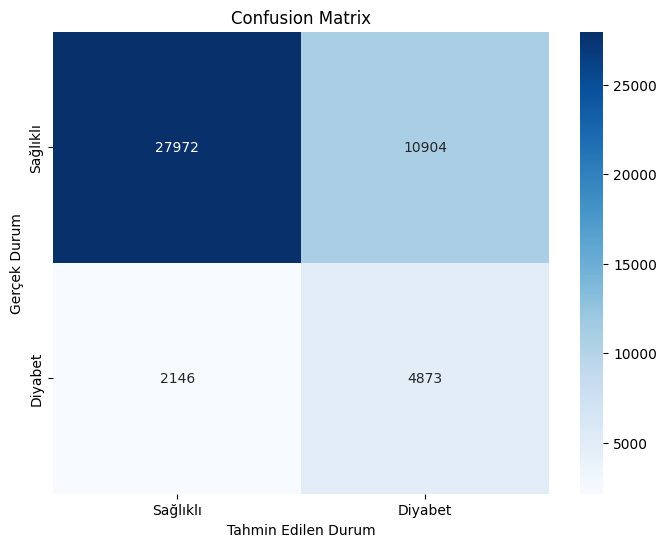

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sağlıklı', 'Diyabet'], yticklabels=['Sağlıklı', 'Diyabet'])
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')
plt.show()

### 5.4 - Loss Curve Visualization


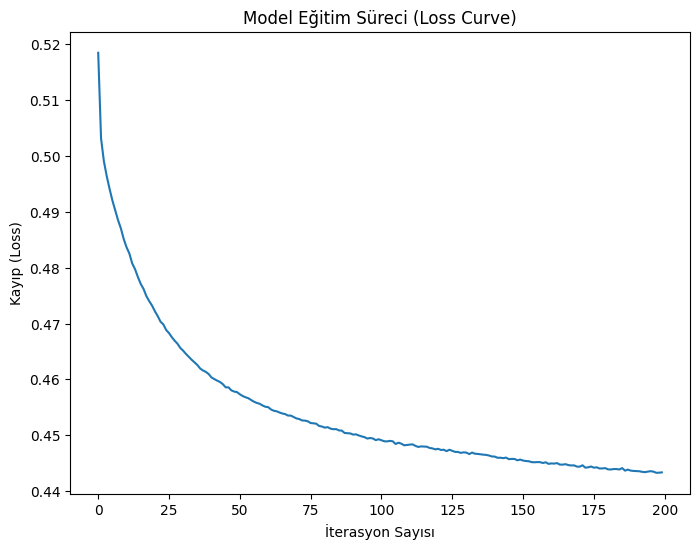

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(best_model.loss_curve_)
plt.title('Model Eğitim Süreci (Loss Curve)')
plt.xlabel('İterasyon Sayısı')
plt.ylabel('Kayıp (Loss)')
plt.show()